# Chest X-ray Pneumonia Detection 🩻

This notebook presents a deep learning approach to classifying chest X-ray images as either *normal* or showing signs of *pneumonia*. The dataset used is the [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) dataset from Kaggle.

The notebook is structured as follows:

1. **Exploratory Data Analysis**: Understand the data distribution and sample characteristics.
2. **Data Preparation**: Preprocessing, augmentation, and dataset loading using PyTorch.
3. **Baseline Model**: A simple CNN trained from scratch to establish a performance benchmark.
4. **Model Improvements**: Architectural refinements, regularization techniques, and training strategies to enhance performance.
5. **Evaluation**: Assess model performance using accuracy, precision, recall, F1-score, and confusion matrices.

📌 **Note**: All models in this notebook are trained from scratch. Pretrained models (e.g., ResNet, VGG) are not used in accordance with project constraints.

🔬 Pneumonia is a serious condition, and automated tools like this have the potential to assist radiologists in improving diagnostic accuracy, especially in resource-limited settings.


# Imports

In [ ]:
!pip install kaggle
!pip install wandb

If you get the following error when running the import cell below this description:


```
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
```
You will need to create a kaggle account, and navigate to https://www.kaggle.com/me/account. Navigate to "API" and create a new token. This will automatically download a json file called "kaggle.json".

Run the following code, replacing the "INSERT JSON HERE TEXT" with the contents of the json that you downloaded.

```
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = {"username":"fernandagbuesomedina","key":"6083e1c7494b6ef2f1a07f881deadba3"}

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json
```

INSERT JSON HERE TEXT should be something of the form:
```
{"username":"XXX","key":"XXX"}
```

In [ ]:
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = {"username":"fernandagbuesomedina","key":"6083e1c7494b6ef2f1a07f881deadba3"}

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json

In [ ]:
import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here.

In [ ]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [ ]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Download complete!


In [ ]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Data re-split complete. New dataset location: chest_xray_dataset_new_split


# Data Analysis

Perform some basic analysis of the statistics of the dataset.

* The dataset, which consisted of 5,863 images classified either as healthy (Normal) or unhealthy (Pneumonia), shows a marked **class imbalance** in the first figure displaying the class distribution. This imbalance can hinder model training by biasing it towards the more frequent class (Pneumonia), potentially reducing its sensitivity to the less represented class (Normal).

* From the second figure that plots different X-Ray images it is notorious that the images display **differences in pixel intensities**, specifically in the diaphragmatic region (bottom part) where high-intensity (bright) pixels are present. This may negatively impact the ability of the model to identify and measure lung disease patterns.

* Finally, the third figure contains the image dimensions showing that there are **images of varying sizes**. Rescaling these image sizes is beneficial for the model as it ensures a consistent input shape, which helps process the images more effectively and focus on learning relevant features rather than adjusting to size differences. This can improve both the stability and accuracy of the training process.


To address these issues, we will use different approaches in the next pre-processing part.


In [ ]:
# Collect dataset statistics
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))

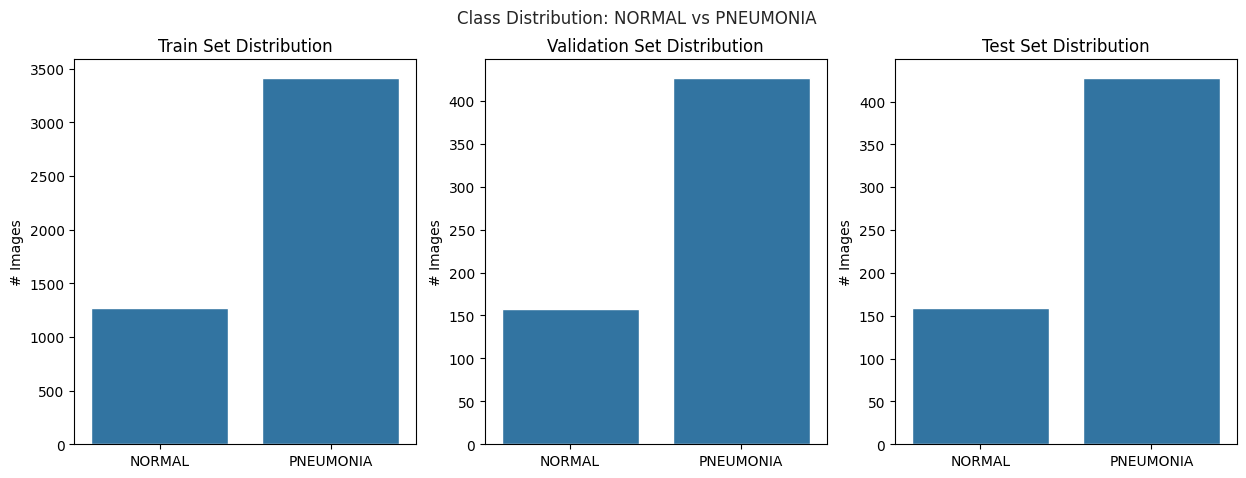

In [ ]:
# CLASS DISTRIBUTION AND DATASET IMBALANCE

train_labels = []
val_labels = []
test_labels = []

for class_name, count in stats['train'].items():
    train_labels.extend([class_name] * count)
for class_name, count in stats['val'].items():
    val_labels.extend([class_name] * count)
for class_name, count in stats['test'].items():
    test_labels.extend([class_name] * count)

# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.set_style('darkgrid')

# Plot for training set
sns.countplot(x=train_labels, ax=axs[0])
axs[0].set_title('Train Set Distribution')
axs[0].set_ylabel('# Images')

# Plot for validation set
sns.countplot(x=val_labels, ax=axs[1])
axs[1].set_title('Validation Set Distribution')
axs[1].set_ylabel('# Images')

# Plot for test set
sns.countplot(x=test_labels, ax=axs[2])
axs[2].set_title('Test Set Distribution')
axs[2].set_ylabel('# Images')

# Display all plots
plt.suptitle('Class Distribution: NORMAL vs PNEUMONIA')
plt.show()

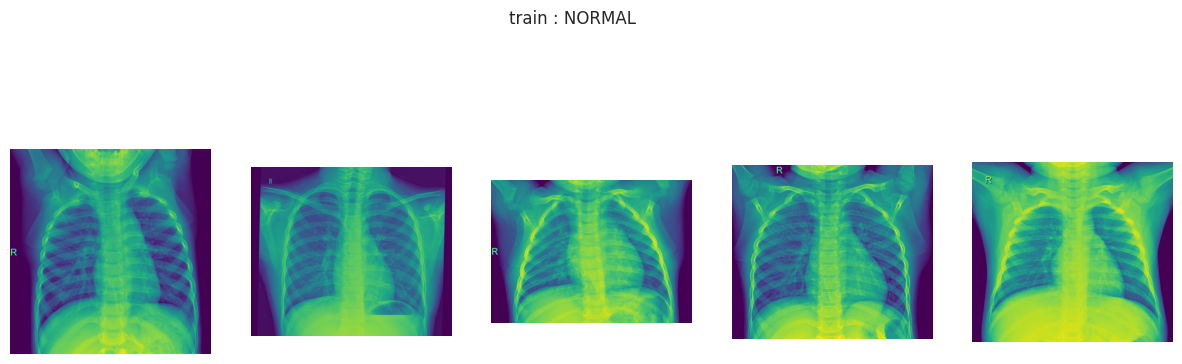

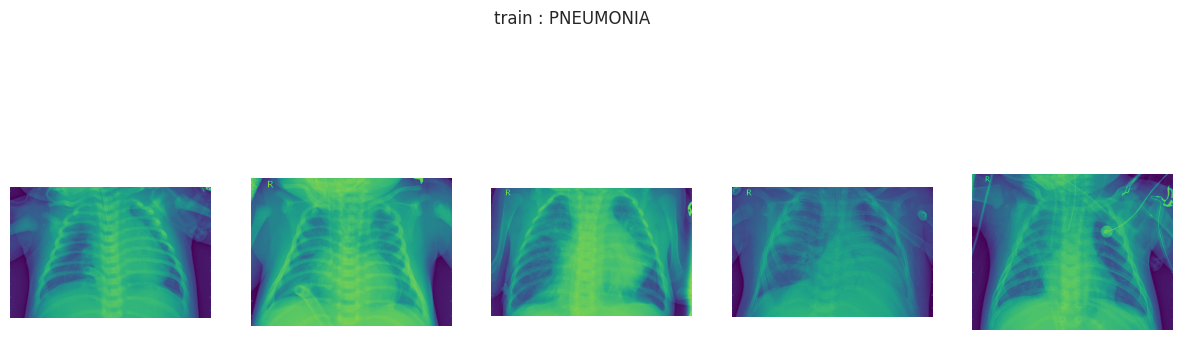

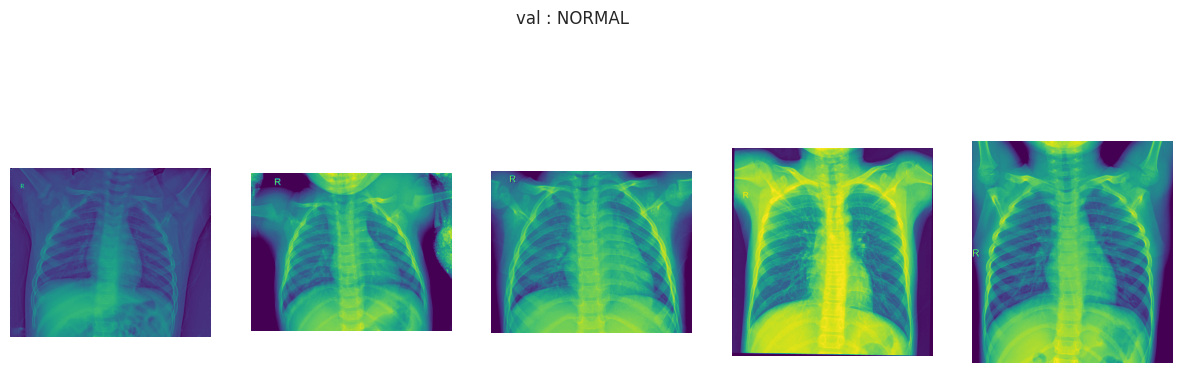

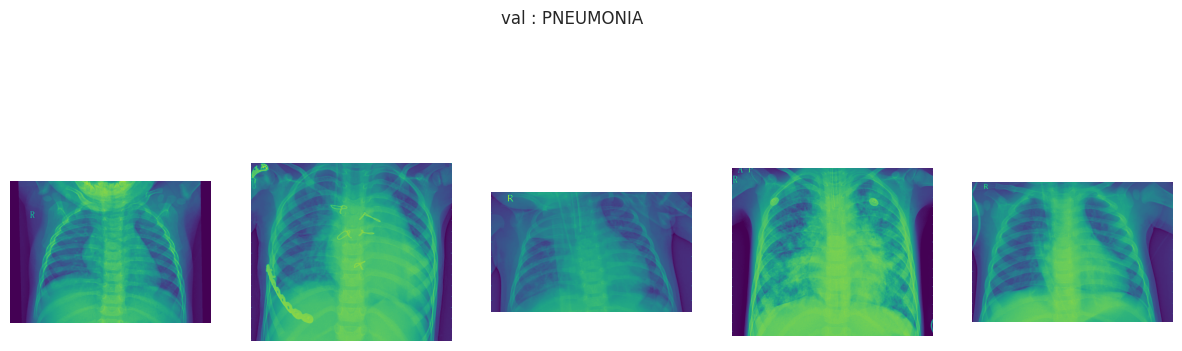

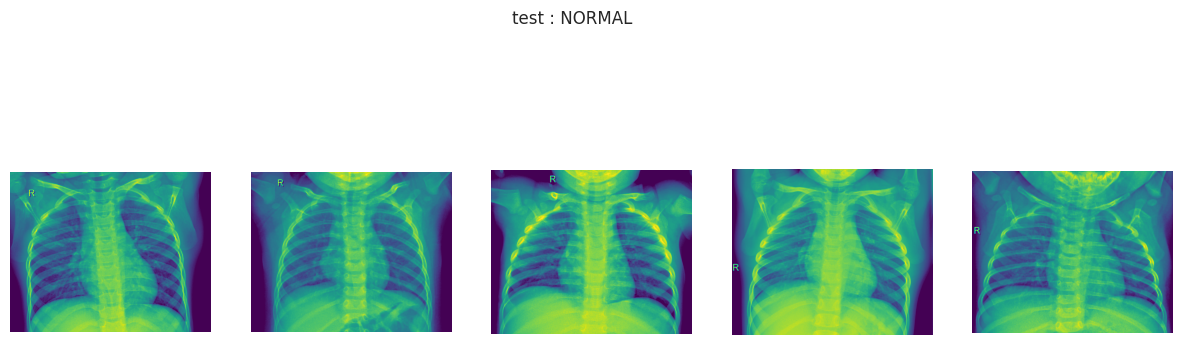

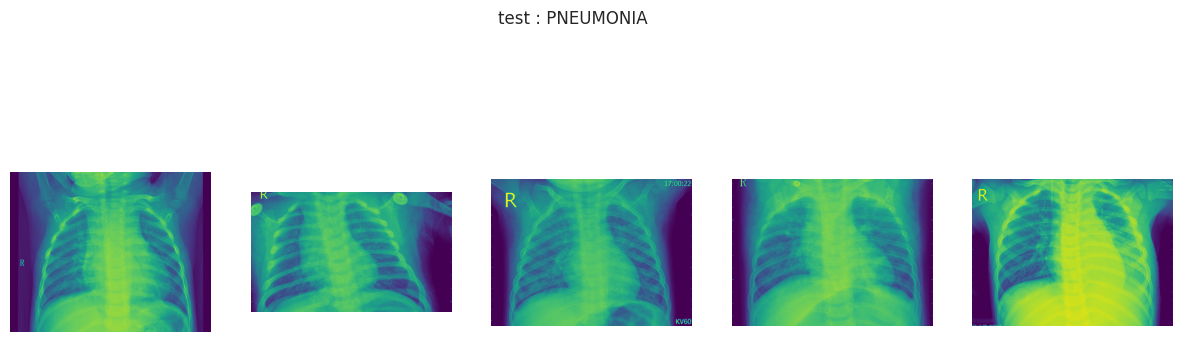

In [ ]:
# PREVIEWING THE IMAGES FOR BOTH CLASSES

# Loop through each split and class
for split in ['train', 'val', 'test']:
    for classes in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(new_dataset_path, split, classes)
        image_files = os.listdir(path)

        # Collect the first 5 images for the current split and class
        images_to_display = []
        for img_file in image_files[:5]:
            img_path = os.path.join(path, img_file)
            img = Image.open(img_path)
            img_array = np.array(img)
            images_to_display.append(img_array)

        # Create a subplot for the collected images
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"{split} : {classes}")

        # Plot each image in a row
        for idx, img_array in enumerate(images_to_display):
            plt.subplot(1, 5, idx + 1)  # Subplot for each image
            plt.imshow(img_array, cmap = 'viridis')
            plt.axis('off')

        plt.show()  # Display images

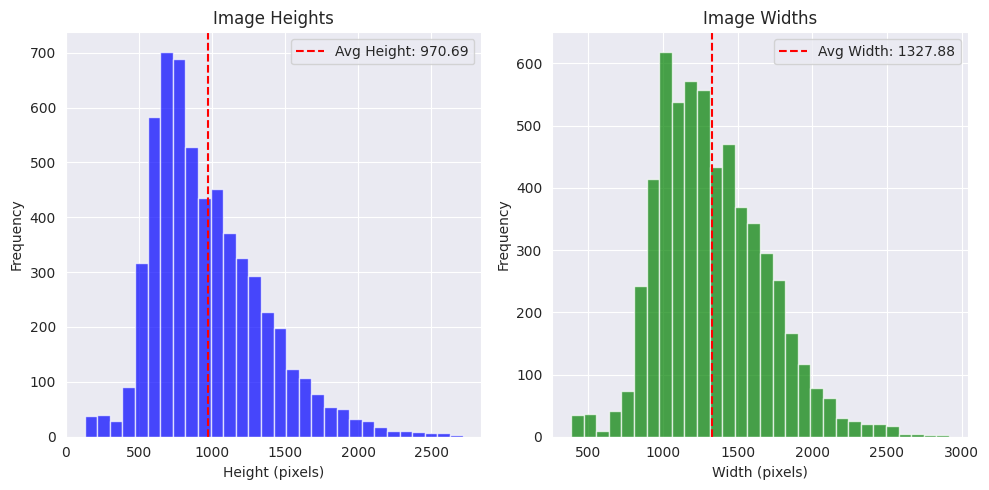

Average Image Height: 970.69 pixels
Average Image Width: 1327.88 pixels


In [ ]:
# COLLECT IMAGE DIMENSIONS

heights = []
widths = []

dataset_path = "/content/chest_xray_dataset_new_split"

# Loop through all images in the dataset
for split in ['train', 'val', 'test']:
    for classes in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(dataset_path, split, classes)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # Open the image and get sizes
                with Image.open(img_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")

heights = np.array(heights)
widths = np.array(widths)

# Calculate avg height and width
avg_height = np.mean(heights)
avg_width = np.mean(widths)

# Plot distribution
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.hist(heights, bins=30, color='blue', alpha=0.7)
plt.axvline(avg_height, color='red', linestyle='--', label=f'Avg Height: {avg_height:.2f}')
plt.title("Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(widths, bins=30, color='green', alpha=0.7)
plt.axvline(avg_width, color='red', linestyle='--', label=f'Avg Width: {avg_width:.2f}')
plt.title("Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

# Print avg dimensions
print(f"Average Image Height: {avg_height:.2f} pixels")
print(f"Average Image Width: {avg_width:.2f} pixels")

# Data Pre-Processing

Load the dataset into torch dataloaders, performing any preprocessing required in the process.

Within the ChestXrayDataset class, the root_dir parameter is a string defining the directory containing the "train", "val" and "test" folders.

* The dataset contains images with varying pixel sizes, which can introduce inconsistencies during training. To address this, images were **rescaled to 256x256 pixels**, balancing computational efficiency with detail preservation.

* Converting images to **grayscale** further reduces computational complexity by decreasing the input channel depth from 3 (RGB) to 1. This is particularly useful in this case where color information is unnecessary because the images are fundamentally monochromatic, with pixel intensity representing tissue density rather than color information. Since the color channels contain redundant intensity information, reducing the image to grayscale removes unnecessary complexity without sacrificing essential detail.

* Finally, normalization was applied using the mean and standard deviation of the training dataset to standardize pixel values, which mitigates illumination differences and enhance training stability and performance.

In [ ]:
dataset_path = "/content/chest_xray_dataset_new_split"
batch_size = 32

In [ ]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Load images and labels
        for classes in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, classes)
            if os.path.isdir(cls_path):
                for img_file in os.listdir(cls_path):
                    img_path = os.path.join(cls_path, img_file)
                    self.images.append(img_path)
                    self.labels.append(0 if classes == 'NORMAL' else 1)  # 0 for NORMAL, 1 for PNEUMONIA

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# Define data transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images 256x256 pixels
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

In [ ]:
# Define the paths for training and validation datasets
train_data_path = os.path.join(new_dataset_path, 'train')
val_data_path = os.path.join(new_dataset_path, 'val')
test_data_path = os.path.join(new_dataset_path, 'test')

# Create datasets
training_data = ChestXrayDataset(root_dir=train_data_path, transform=transform)
validation_data = ChestXrayDataset(root_dir=val_data_path, transform=transform)
test_data = ChestXrayDataset(root_dir=test_data_path, transform=transform)

# Create data loaders
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    validation_data,
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
)

In [ ]:
mean = 0.
std = 0.

# Calculate the mean and std dev of training data
for images, _ in train_dataloader:
    batch_samples = images.size(0)
    images = images.view(batch_size, -1)
    mean += images.mean(1).sum()
    std += images.std(1).sum()

mean /= len(train_dataloader.dataset)
std /= len(train_dataloader.dataset)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: 0.4831838011741638
Standard Deviation: 0.22262409329414368


In [ ]:
# Define final data transforms
final_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images 256x256
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((mean,), (std,))  # Normalize
])

In [ ]:
# Create datasets
training_data = ChestXrayDataset(root_dir=train_data_path, transform=final_transform)
validation_data = ChestXrayDataset(root_dir=val_data_path, transform=final_transform)
test_data = ChestXrayDataset(root_dir=test_data_path, transform=final_transform)

# Create data loaders
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    validation_data,
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
)

# Print dataset sizes
print(f"Training dataset size: {len(training_data)}")
print(f"Validation dataset size: {len(validation_data)}")
print(f"Test dataset size: {len(test_data)}")

# Print batch shapes
for X, y in train_dataloader:
    print(f"Shape of X [B, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break  # Only print the shape of the first batch

Training dataset size: 4684
Validation dataset size: 585
Test dataset size: 587
Shape of X [B, C, H, W]: torch.Size([32, 1, 256, 256])
Shape of y: torch.Size([32]) torch.int64


# Training a Baseline

Establish an initial baseline model and training procedure. This should be as simple as possible, without using any elaborate design choices, whilst still obtaining reasonable performance (i.e., at least better than random chance). We will attempt to improve upon this baseline in later questions.

What makes a good baseline:
* Easily converges;
* Easy to implement;
* Established architectural components that have proved well suited to the data-type and problem.
* Obtains reasonable performance e.g, better than random guess


### **Design Choices**

**Table 1.**

Baseline Model Architecture.
<table>
  <tr>
  <tr>
    <th>Number</th>
    <th>Layer</th>
    <th>Size</th>
    <th>Activation</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Input Image</td>
    <td>256 x 256 x 1</td>
    <td> - - - - - - - </td>
  </tr>
  <tr>
    <td>1</td>
    <td>2× Convolution (3 ×3)</td>
    <td>256 x 256 x 16</td>
    <td>ReLU</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Max Pooling</td>
    <td>128 x 128 x 16</td>
    <td> - - - - - - - </td>
  </tr>
  <tr>
    <td>3</td>
    <td>2× Convolution (3 ×3)</td>
    <td>64 x 64 x 32</td>
    <td>ReLU</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Max Pooling</td>
    <td>64 x 64 x 32</td>
    <td> - - - - - - - </td>
  </tr>
  <tr>
    <td>5</td>
    <td>2× Convolution (3 ×3)</td>
    <td>32 x 32 x 64</td>
    <td>ReLU</td>
  </tr>
  <tr>
    <td>6</td>
    <td>Max Pooling</td>
    <td>32 x 32 x 64</td>
    <td> - - - - - - - </td>
  </tr>
 <tr>
    <td>7</td>
    <td>Flattening</td>
    <td>65,536</td>
    <td> - - - - - - - </td>
  </tr>
 <tr>
    <td>8</td>
    <td>Fully Connected</td>
    <td>32 x 32 x 64</td>
    <td>Sigmoid </td>
  </tr>
  </table>


* Architecture: Three convolutional layers each followed by ReLU activation and max pooling, is minimal but sufficient to capture core spatial patterns typical in medical imaging without being overly complex.
* Binary Cross-Entropy (BCE) Loss: Since this is a binary classification task (Normal vs. Pneumonia), BCE Loss is a straightforward and effective choice that will guide the model in minimizing misclassification.
* Adam Optimizer: Adam is commonly used in image classification tasks due to its adaptive learning rate and ability to converge quickly.
* Number of Epochs: Setting num_epochs = 12 is sufficient for the baseline. This keeps training time manageable while giving the model enough iterations to start capturing patterns in the data.

Different hyperparameter combinations were tested for stabilizing optimization (learning rate, batch size, preprocessing). Three learning rates (0.01, 0.001, and 0.0001) and two batch sizes (32 and 64) were varied. It was observed that smaller learning rates and batch sizes yielded better convergence results. This indicates that fine-tuning these hyperparameters can significantly enhance the model's training stability and overall performance.

  **Table 2.**

Model final parameters.
<table>
  <tr>
    <th>Batch Size</th>
    <th>Number of Epochs</th>
    <th>Learning Rate</th>
    <th>Optimizer</th>
    <th>Kernel Size</th>
  </tr>
  <tr>
    <td>32</td>
    <td>12</td>
    <td>0.001</td>
    <td>Adam</td>
    <td>3x3</td>
  </tr>
  </table>

In [ ]:
num_epochs = 12
use_wandb = False  # Set to True if you want to use wandb
lr = 0.001

In [ ]:
# Define the model
from torchsummary import summary

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the layers
        self.layers = nn.ModuleList([
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third convolutional layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ])

        # Flatten layer
        self.flatten = nn.Flatten()
        # Fully connected layer:
        self.fc = nn.Linear(64 * 32 * 32, 1)  # Output layer 256 (pixels) / 2^3(pooling layers)

      # Define the forward pass
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)  # Pass the input through each layer
        x = self.flatten(x)  # Flatten the output before the fully connected layer
        x = self.fc(x)  # Pass through the fully connected layer
        x = torch.sigmoid(x)  # Apply sigmoid activation to the output
        return x

model = SimpleModel().to(device)
summary(model, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
              ReLU-5         [-1, 32, 128, 128]               0
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Flatten-10                [-1, 65536]               0
           Linear-11                    [-1, 1]          65,537
Total params: 88,833
Trainable params: 88,833
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/ba

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=False):
    # Lists to store metrics
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    train_class_accuracies, val_class_accuracies = [], []

    # Lists to store values for confusion matrix
    y_true, y_pred = [], []

    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()

        # Initialize epoch metrics
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            y = y.float()

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y.unsqueeze(1))

            # Backward pass and optimization
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()        # Backpropagation
            optimizer.step()       # Update weights

            # Track metrics
            running_loss += loss.item() * X.size(0)  # Accumulate loss

            predicted = (outputs > 0.5).float()  # Threshold for binary classification
            total += y.size(0)
            correct += (predicted.squeeze() == y).sum().item()  # Count correct predictions

        # Calculate training loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        y_true, y_pred = [], []  # Reset for each epoch


        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_val = y_val.float()

                # Forward pass
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val.unsqueeze(1))

                # Track validation metrics
                val_running_loss += val_loss.item() * X_val.size(0)
                val_predicted = (val_outputs > 0.5).float()  # Threshold for binary classification
                val_total += y_val.size(0)
                val_correct += (val_predicted.squeeze() == y_val).sum().item()

                # Store values for confusion matrix
                y_true.extend(y_val.cpu().numpy())  # true labels
                y_pred.extend(val_predicted.squeeze().cpu().numpy())  # predictions

        # Calculate validation loss and accuracy
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        # Print metrics for the current epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, y_true, y_pred

In [ ]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies):

    epochs = range(1, len(train_losses) + 1)

    # Plotting the training and validation losses
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate precision, accuracy, sensitivity (recall) and specificity
def calculate_metrics(conf_matrix):
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]

    accuracy = (TP + TN) / np.sum(conf_matrix)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    # Calculate F1 Score
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    return accuracy, precision, sensitivity, specificity, f1_score

In [ ]:
# Initialize the model
model = SimpleModel().to(device)

# DEFINE LOSS FUNCTION AND OPTIMIZER
criterion = nn.BCELoss()
# Adam optimizer with a starting learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, y_true, y_pred = train_model(
    model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device, use_wandb
)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

Epoch [1/12], Train Loss: 0.2674, Train Accuracy: 0.8883, Val Loss: 0.1111, Val Accuracy: 0.9641
Epoch [2/12], Train Loss: 0.1345, Train Accuracy: 0.9526, Val Loss: 0.0863, Val Accuracy: 0.9692
Epoch [3/12], Train Loss: 0.1169, Train Accuracy: 0.9588, Val Loss: 0.0965, Val Accuracy: 0.9641
Epoch [4/12], Train Loss: 0.0981, Train Accuracy: 0.9633, Val Loss: 0.1018, Val Accuracy: 0.9573
Epoch [5/12], Train Loss: 0.0824, Train Accuracy: 0.9708, Val Loss: 0.0875, Val Accuracy: 0.9641
Epoch [6/12], Train Loss: 0.0558, Train Accuracy: 0.9804, Val Loss: 0.1023, Val Accuracy: 0.9658
Epoch [7/12], Train Loss: 0.0391, Train Accuracy: 0.9885, Val Loss: 0.1056, Val Accuracy: 0.9675
Epoch [8/12], Train Loss: 0.0262, Train Accuracy: 0.9923, Val Loss: 0.1224, Val Accuracy: 0.9658
Epoch [9/12], Train Loss: 0.0172, Train Accuracy: 0.9951, Val Loss: 0.1413, Val Accuracy: 0.9590
Epoch [10/12], Train Loss: 0.0091, Train Accuracy: 0.9964, Val Loss: 0.1416, Val Accuracy: 0.9658
Epoch [11/12], Train Loss: 0.

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

###**Results**

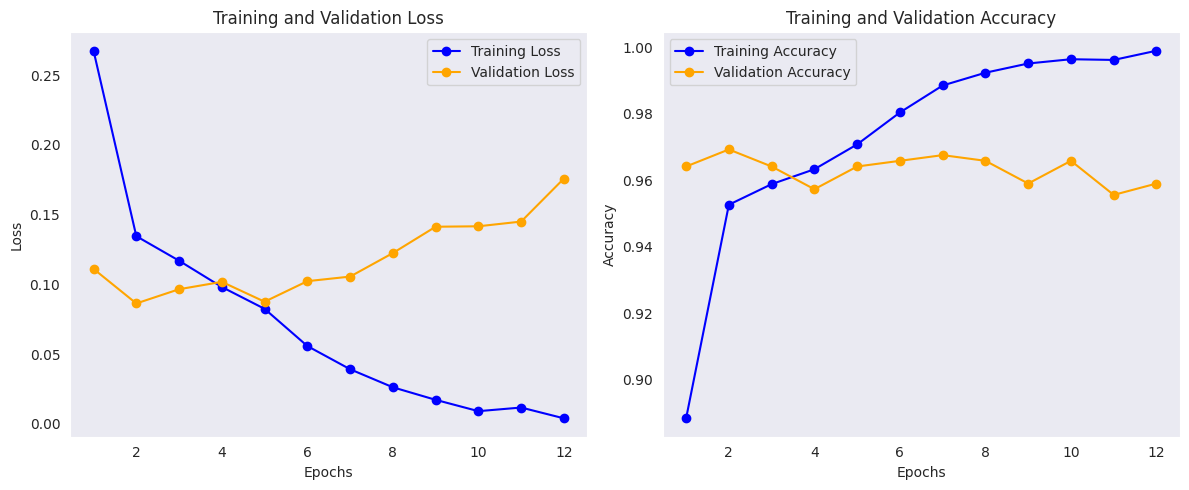

In [ ]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

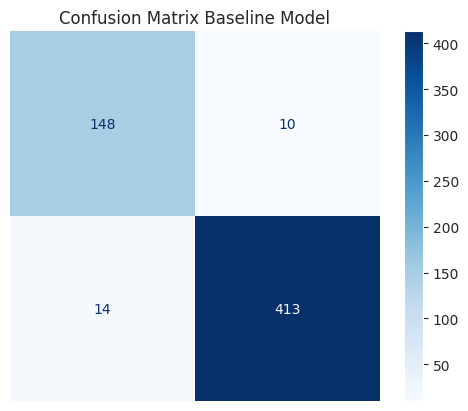

In [ ]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Baseline Model')
plt.axis('off')
plt.show()

In [ ]:
accuracy, precision, sensitivity, specificity, f1_score = calculate_metrics(conf_matrix)

# Print metrics
print(f'BASELINE MODEL')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score: {f1_score:.4f}')

BASELINE MODEL
Accuracy: 0.9590
Precision: 0.9764
Sensitivity (Recall): 0.9672
Specificity: 0.9367
F1 Score: 0.9718


### **Discussion of Results**

A model's loss value indicates its performance across iterations, with lower loss typically signifying improved learning. However, when overfitting occurs, low training loss may not reflect true generalization to new data. In this baseline model, training and validation loss values, as visualized in Figure 1, offer insight into this dynamic. Over successive epochs, training loss consistently decreases suggesting the model is effectively capturing patterns in the training data. However, after around epoch 7, validation loss begins to diverge from training loss highlighting the onset of overfitting. On average, the model's loss rate decreased as epochs progressed, but the widening gap between training and validation loss indicates that the model's performance on unseen data may not be as strong as on the training set.

# Improving the Baseline

Building on the baseline model, this section explores potential improvements to enhance classification performance. Based on the baseline results and training behavior, we identify key areas where model architecture, training strategy, or data handling can be optimized.

While multiple ideas may be tested during experimentation, the final implementation focuses on **three targeted design choices** that aim to address specific limitations observed in the baseline. These modifications are justified through both qualitative reasoning and quantitative evaluation.

## Final improved model -- baseline + 3 improvements



###**Final Improved Model**

Since in the baseline we observed diminishing returns in validation loss after a certain point (implying overfitting) the following techniques were applied to help the model generalize better and be more robust:

1.   **Data Augmentation:** increases the diversity of the training dataset by creating new, varied examples that help the model generalize better.
2.   **Dropout:** helps mitigate overfitting by randomly “dropping out” neurons during training, which encourages the model to learn more distributed and robust representations. By applying dropout, the model learns to generalize without relying too heavily on specific neurons or patterns, which improves performance on unseen validation data.
3.   **Early Stopping:** Early stopping prevents overfitting by halting training once the model's validation performance plateaus or worsens.

In [ ]:
# EARLY STOPPING

import copy

def train_model_early_stop(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=False):
    # Lists to store metrics
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    train_class_accuracies, val_class_accuracies = [], []

    # Lists values for confusion matrix
    y_true, y_pred = [], []

    best_loss = float('inf')  # Initialize best_loss
    patience = 4  # Set the patience
    counter = 0  # Initialize counter

    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()

        # Initialize epoch metrics
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            y = y.float()

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y.unsqueeze(1))

            # Backward pass and optimization
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()        # Backpropagation
            optimizer.step()       # Update weights

            # Track metrics
            running_loss += loss.item() * X.size(0)  # Accumulate loss

            predicted = (outputs > 0.5).float()  # Threshold for binary classification
            total += y.size(0)
            correct += (predicted.squeeze() == y).sum().item()  # Count correct predictions

        # Calculate training loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        y_true, y_pred = [], []  # Reset for each epoch

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_val = y_val.float()

                # Forward pass
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val.unsqueeze(1))

                # Track validation metrics
                val_running_loss += val_loss.item() * X_val.size(0)
                val_predicted = (val_outputs > 0.5).float()  # Threshold for binary classification
                val_total += y_val.size(0)
                val_correct += (val_predicted.squeeze() == y_val).sum().item()

                # Store true and predicted values for confusion matrix
                y_true.extend(y_val.cpu().numpy())  # true labels
                y_pred.extend(val_predicted.squeeze().cpu().numpy())  # predictions

        # Calculate validation loss and accuracy
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        # Print metrics for the current epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

        # Early stopping
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            counter = 0  # Reset counter
        else:
            counter += 1  # Increment counter if no improvement
            if counter >= patience:  # stop training
                print("Early stopping triggered.")
                model.load_state_dict(best_model_weights)  # load best model weights
                break

    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, y_true, y_pred

In [ ]:
num_epochs = 30
use_wandb = False  # Set to True if you want to use wandb
lr = 0.001

In [ ]:
# DATA AUGMENTATION

# Define transformations
optimized_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),          # Randomly flip the image horizontally
    transforms.RandomRotation(10),              # Rotate the image by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Create datasets
training_data = ChestXrayDataset(root_dir=train_data_path, transform=optimized_transform) # Only apply data augmentation to training set
validation_data = ChestXrayDataset(root_dir=val_data_path, transform=final_transform)
test_data = ChestXrayDataset(root_dir=test_data_path, transform=final_transform)

# Create data loaders
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    validation_data,
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
)

In [ ]:
# Define the model

class OptimizedModel(nn.Module):

    def __init__(self):
        super().__init__()

        # Define the layers
        self.layers = nn.ModuleList([
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1),

            # Second convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1),

            # Third convolutional layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        ])

        # Flatten layer
        self.flatten = nn.Flatten()
        # Dropout before fully connected layer
        self.dropout = nn.Dropout(0.5)
        # Fully connected layer
        self.fc = nn.Linear(64 * 32 * 32, 1)  # Output layer 256 (pixels) / 2^3 (# pooling layers)

      # Define the forward pass
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)  # Pass the input through each layer
        x = self.flatten(x)  # Flatten the output before the fully connected layer
        x = self.fc(x)  # Pass through the fully connected layer
        x = torch.sigmoid(x)  # Apply sigmoid activation to the output
        return x

optimized_model = OptimizedModel().to(device)
summary(optimized_model, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
           Dropout-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           4,640
              ReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
           Dropout-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
             ReLU-10           [-1, 64, 64, 64]               0
        MaxPool2d-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
          Flatten-13                [-1, 65536]               0
           Linear-14                   

In [ ]:
# Initialize the model
optimized_model = OptimizedModel().to(device)

# DEFINE LOSS FUNCTION AND OPTIMIZER
criterion = nn.BCELoss()
# Adam optimizer with a starting learning rate
optimizer = optim.Adam(optimized_model.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, y_true, y_pred = train_model_early_stop(
    optimized_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device, use_wandb
)

# Save the model
torch.save(optimized_model.state_dict(), 'chest_xray_optimized_model.pth')
print("Model saved as 'chest_xray_optimized_model.pth'")

Epoch [1/30], Train Loss: 0.3177, Train Accuracy: 0.8642, Val Loss: 0.1752, Val Accuracy: 0.9316
Epoch [2/30], Train Loss: 0.2129, Train Accuracy: 0.9195, Val Loss: 0.2184, Val Accuracy: 0.9145
Epoch [3/30], Train Loss: 0.1801, Train Accuracy: 0.9340, Val Loss: 0.1300, Val Accuracy: 0.9538
Epoch [4/30], Train Loss: 0.1585, Train Accuracy: 0.9415, Val Loss: 0.1541, Val Accuracy: 0.9350
Epoch [5/30], Train Loss: 0.1500, Train Accuracy: 0.9432, Val Loss: 0.2127, Val Accuracy: 0.9111
Epoch [6/30], Train Loss: 0.1528, Train Accuracy: 0.9445, Val Loss: 0.1271, Val Accuracy: 0.9556
Epoch [7/30], Train Loss: 0.1347, Train Accuracy: 0.9490, Val Loss: 0.0950, Val Accuracy: 0.9692
Epoch [8/30], Train Loss: 0.1320, Train Accuracy: 0.9515, Val Loss: 0.0969, Val Accuracy: 0.9675
Epoch [9/30], Train Loss: 0.1377, Train Accuracy: 0.9471, Val Loss: 0.0961, Val Accuracy: 0.9624
Epoch [10/30], Train Loss: 0.1210, Train Accuracy: 0.9545, Val Loss: 0.1004, Val Accuracy: 0.9641
Epoch [11/30], Train Loss: 0.

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

###**Results**

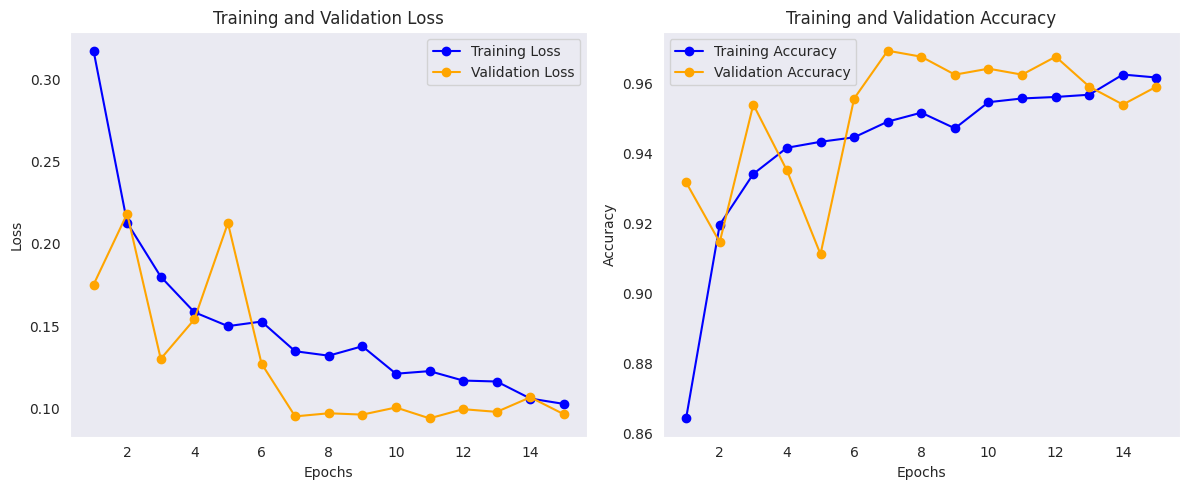

In [ ]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

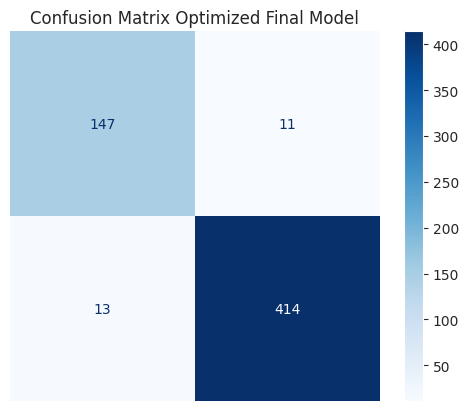

In [ ]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Optimized Final Model')
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
accuracy, precision, sensitivity, specificity, f1_score = calculate_metrics(conf_matrix)

# Print metrics
print(f'OPTIMIZED FINAL MODEL')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score: {f1_score:.4f}')

OPTIMIZED FINAL MODEL
Accuracy: 0.9590
Precision: 0.9741
Sensitivity (Recall): 0.9696
Specificity: 0.9304
F1 Score: 0.9718


###**Discussion of Results**

When comparing the loss curves of the two models, the optimized model's validation loss is notably more consistent, underscoring its improved generalizability. This advantage is better depicted in the graph of the loss and accuracy curves. In terms of computational efficiency, the optimized model presents a significant benefit. By incorporating early stopping, the model minimizes unnecessary computations and avoids overfitting, which contributes to faster training times (particularly valuable given limited time and computational resources).

The optimized model shows a slight improvement over the baseline in validation performance. These results demonstrate that the modifications positively impacted the model's ability to generalize to unseen data, leading to higher overall performance.

## Improvement 1: Data Augmentation

###**Data Augmentation**

The dataset exhibits an imbalance in class distribution, particularly with the 'normal' class. By applying carefully chosen data augmentation techniques, the training set can be diversified allowing the model to learn more robust features associated with the minority class. This approach helps the model generalize better by exposing it to slight variations in the data.

In medical imaging, context is critical when selecting augmentation techniques. Not every transformation would make sense, as some may introduce unrealistic variations that could mislead the model. For example, a vertical flip would not be appropriate in a radiology setting as it could distort the anatomical structure and create images that are not physiologically accurate.

The two data augmentation approaches chosen are viable because it is plausible to encounter variations in imaging conditions and slight shifts in patient orientation. Specifically, these techniques applied during training include:

1.	Randomly flipping the image horizontally with a 50% probability.
2.	Randomly rotating the image by an angle of up to ±10 degrees.


In [ ]:
# Initial model parameters for comparison
num_epochs = 12
use_wandb = False  # Set to True if you want to use wandb
lr = 0.001

In [ ]:
# Improvement 1: DATA AUGMENTATION

# Create datasets
training_data = ChestXrayDataset(root_dir=train_data_path, transform=optimized_transform) # Only apply data augmentation to training set
validation_data = ChestXrayDataset(root_dir=val_data_path, transform=final_transform)
test_data = ChestXrayDataset(root_dir=test_data_path, transform=final_transform)

# Create data loaders
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    validation_data,
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
)

# Initialize the model
model = SimpleModel().to(device)

# Adam optimizer with a starting learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, y_true, y_pred = train_model(
    model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device, use_wandb
)

Epoch [1/12], Train Loss: 0.2813, Train Accuracy: 0.8866, Val Loss: 0.1271, Val Accuracy: 0.9504
Epoch [2/12], Train Loss: 0.1597, Train Accuracy: 0.9404, Val Loss: 0.1074, Val Accuracy: 0.9590
Epoch [3/12], Train Loss: 0.1506, Train Accuracy: 0.9458, Val Loss: 0.1008, Val Accuracy: 0.9675
Epoch [4/12], Train Loss: 0.1412, Train Accuracy: 0.9498, Val Loss: 0.0877, Val Accuracy: 0.9641
Epoch [5/12], Train Loss: 0.1338, Train Accuracy: 0.9515, Val Loss: 0.0972, Val Accuracy: 0.9641
Epoch [6/12], Train Loss: 0.1278, Train Accuracy: 0.9513, Val Loss: 0.0900, Val Accuracy: 0.9709
Epoch [7/12], Train Loss: 0.1253, Train Accuracy: 0.9539, Val Loss: 0.0981, Val Accuracy: 0.9658
Epoch [8/12], Train Loss: 0.1243, Train Accuracy: 0.9552, Val Loss: 0.0841, Val Accuracy: 0.9726
Epoch [9/12], Train Loss: 0.1126, Train Accuracy: 0.9603, Val Loss: 0.0887, Val Accuracy: 0.9624
Epoch [10/12], Train Loss: 0.1041, Train Accuracy: 0.9603, Val Loss: 0.1039, Val Accuracy: 0.9573
Epoch [11/12], Train Loss: 0.

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

###**Results**

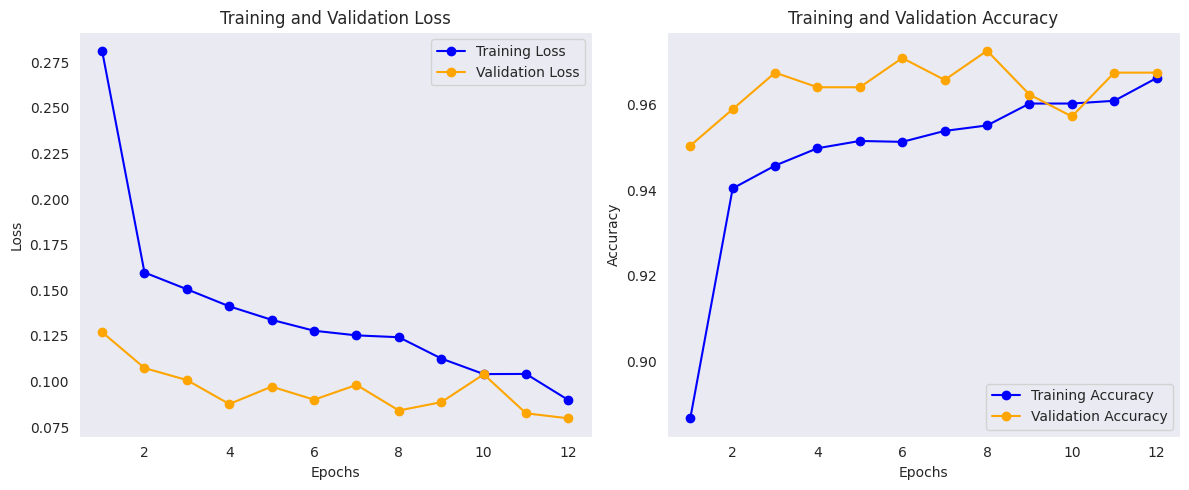

In [ ]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

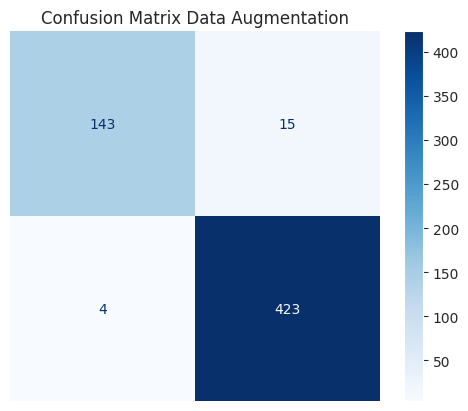

In [ ]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Data Augmentation')
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
accuracy, precision, sensitivity, specificity, f1_score = calculate_metrics(conf_matrix)

# Print metrics
print(f'DATA AUGMENTATION MODEL')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score: {f1_score:.4f}')

DATA AUGMENTATION MODEL
Accuracy: 0.9675
Precision: 0.9658
Sensitivity (Recall): 0.9906
Specificity: 0.9051
F1 Score: 0.9780


###**Discussion of Results**

The consistency of validation accuracy and the generally stable validation loss (without large fluctuations) suggest that the model is not overfitting, indicating that data augmentation has enhanced generalizability.

The implementation of this techniques resulted in an improvement in the model's accuracy. In terms of the 'normal' class detection, the increase in specificity implies that the model has become better at distinguishing this cases from the 'pneumonia' class, reducing false positives. Overall, data augmentation has positively impacted the model's performance across multiple metrics.

The results highlight the necessity of data augmentation in medical imaging, especially given the inherent variability in X-ray images due to factors like patient positioning and equipment differences. Augmentation techniques enhance dataset diversity, which is crucial in this context where datasets are often limited in size and variety. This diversity helps prevent overfitting by exposing the model to a broader range of variations, developing a more reliable diagnostic tool.

## Improvement 2: Dropout

###**Dropout**

The baseline model exhibited strong performance on training data but showed signs of overfitting, with a gap between training and validation accuracy. To avoid this, dropout was implemented in the model in the following ways:

* The first two convolutional layers use dropout rates of 0.1. This allows for a slight regularization without losing too much information from the feature extraction process.
* The third convolutional layer has a slightly higher dropout rate of 0.2, as deeper layers might capture more abstract features a bit more regularization is beneficial.
* Since fully connected layers have a larger number of parameters and are more prone to overfitting, applying a higher dropout rate (0.5) helps to ensure that the model does not overfit on the training data.

In [ ]:
# Initial model parameters for comparison
num_epochs = 12
use_wandb = False  # Set to True if you want to use wandb
lr = 0.001

In [ ]:
# Improvement 2: DROPOUT

# Create datasets
training_data = ChestXrayDataset(root_dir=train_data_path, transform=final_transform)
validation_data = ChestXrayDataset(root_dir=val_data_path, transform=final_transform)
test_data = ChestXrayDataset(root_dir=test_data_path, transform=final_transform)

# Create data loaders
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    validation_data,
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
)

class DropoutModel(nn.Module):

    def __init__(self):
        super().__init__()

        # Define the layers
        self.layers = nn.ModuleList([
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1),

            # Second convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1),

            # Third convolutional layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        ])

        # Flatten layer
        self.flatten = nn.Flatten()
        # Dropout before fully connected layer
        self.dropout = nn.Dropout(0.5)
        # Fully connected layer
        self.fc = nn.Linear(64 * 32 * 32, 1)  # Output layer 256 (pixels) / 2^3 (# pooling layers)

      # Define the forward pass
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)  # Pass the input through each layer
        x = self.flatten(x)  # Flatten the output before the fully connected layer
        x = self.fc(x)  # Pass through the fully connected layer
        x = torch.sigmoid(x)  # Apply sigmoid activation to the output
        return x

In [ ]:
# Initialize the model
dropout_model = DropoutModel().to(device)

# DEFINE LOSS FUNCTION AND OPTIMIZER
criterion = nn.BCELoss()
# Adam optimizer with a starting learning rate
optimizer = optim.Adam(dropout_model.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, y_true, y_pred = train_model(
    dropout_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device, use_wandb
)

Epoch [1/12], Train Loss: 0.2698, Train Accuracy: 0.8862, Val Loss: 0.1134, Val Accuracy: 0.9521
Epoch [2/12], Train Loss: 0.1461, Train Accuracy: 0.9475, Val Loss: 0.1283, Val Accuracy: 0.9504
Epoch [3/12], Train Loss: 0.1146, Train Accuracy: 0.9575, Val Loss: 0.1111, Val Accuracy: 0.9607
Epoch [4/12], Train Loss: 0.1084, Train Accuracy: 0.9607, Val Loss: 0.1061, Val Accuracy: 0.9624
Epoch [5/12], Train Loss: 0.0842, Train Accuracy: 0.9690, Val Loss: 0.0979, Val Accuracy: 0.9658
Epoch [6/12], Train Loss: 0.0821, Train Accuracy: 0.9705, Val Loss: 0.1036, Val Accuracy: 0.9641
Epoch [7/12], Train Loss: 0.0610, Train Accuracy: 0.9772, Val Loss: 0.1064, Val Accuracy: 0.9624
Epoch [8/12], Train Loss: 0.0461, Train Accuracy: 0.9831, Val Loss: 0.1282, Val Accuracy: 0.9607
Epoch [9/12], Train Loss: 0.0385, Train Accuracy: 0.9855, Val Loss: 0.1786, Val Accuracy: 0.9453
Epoch [10/12], Train Loss: 0.0303, Train Accuracy: 0.9898, Val Loss: 0.1438, Val Accuracy: 0.9573
Epoch [11/12], Train Loss: 0.

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

###**Results**

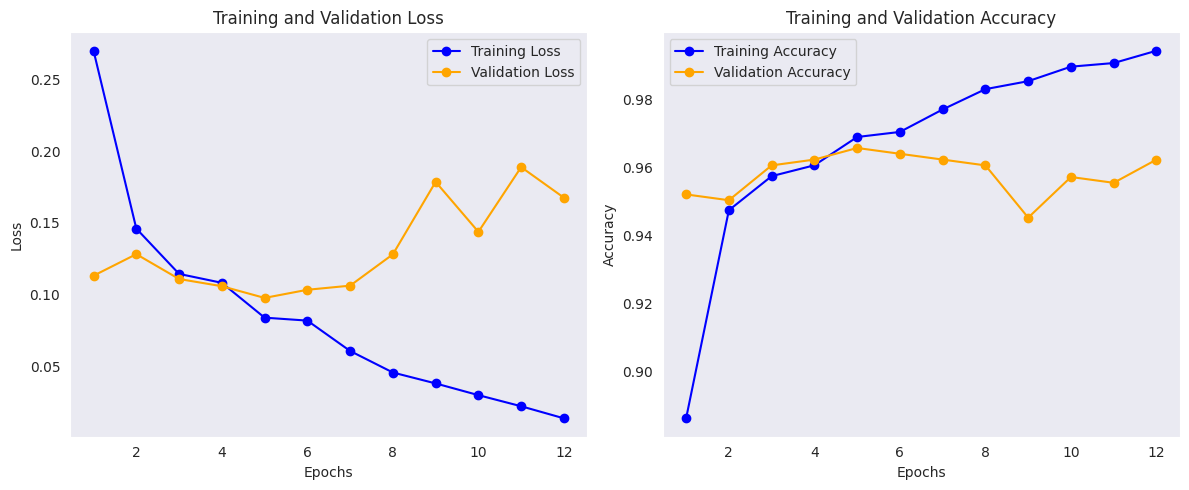

In [ ]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

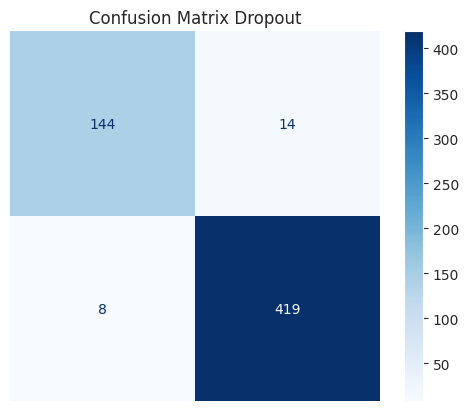

In [ ]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Dropout')
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
accuracy, precision, sensitivity, specificity, f1_score = calculate_metrics(conf_matrix)

# Print metrics
print(f'DROPOUT MODEL')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score: {f1_score:.4f}')

DROPOUT MODEL
Accuracy: 0.9624
Precision: 0.9677
Sensitivity (Recall): 0.9813
Specificity: 0.9114
F1 Score: 0.9744


### **Discussion of Results**

The introduction of dropout appears to provide some regularization benefits, as indicated by the improvement in validation accuracy during the initial epochs. However, towards the later epochs (around epoch 8), the model's performance shows signs of overfitting. While the training accuracy continues to rise, the validation accuracy fluctuates, and the validation loss increases. This divergence suggests that the model is learning the training data very well but may not be generalizing effectively to the validation set. The increasing validation loss towards the end is a red flag, implying that the model is beginning to memorize the training data rather than learning generalized features. This may indicate that additional regularization techniques or adjustments are needed to further enhance the model's ability to generalize.

## Improvement 3: Early Stopping

###**Early Stopping**

Early stopping with a patience of 4 was implemented to halt training when validation performance stopped improving for 4 consecutive epochs. This approach optimizes both model performance and computational resources, as it stops training before the model begins overfitting to the training data, thus enhancing its generalization to unseen data. By using a short patience value, we quickly detect a lack of improvement and avoid wasting resources on further epochs that offer no benefit to validation performance.

In [ ]:
# Improvement 3: EARLY STOPPING

num_epochs = 30
use_wandb = False  # Set to True if you want to use wandb
lr = 0.001

In [ ]:
# Create datasets
training_data = ChestXrayDataset(root_dir=train_data_path, transform=final_transform)
validation_data = ChestXrayDataset(root_dir=val_data_path, transform=final_transform)
test_data = ChestXrayDataset(root_dir=test_data_path, transform=final_transform)

# Create data loaders
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    validation_data,
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
)

In [ ]:
# Initialize the model
model = SimpleModel().to(device)

# DEFINE LOSS FUNCTION AND OPTIMIZER
criterion = nn.BCELoss()
# Adam optimizer with a starting learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, y_true, y_pred = train_model_early_stop(
    model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device, use_wandb
)

Epoch [1/30], Train Loss: 0.2449, Train Accuracy: 0.9088, Val Loss: 0.1285, Val Accuracy: 0.9487
Epoch [2/30], Train Loss: 0.1291, Train Accuracy: 0.9515, Val Loss: 0.0931, Val Accuracy: 0.9675
Epoch [3/30], Train Loss: 0.1156, Train Accuracy: 0.9605, Val Loss: 0.0999, Val Accuracy: 0.9641
Epoch [4/30], Train Loss: 0.0968, Train Accuracy: 0.9633, Val Loss: 0.0949, Val Accuracy: 0.9658
Epoch [5/30], Train Loss: 0.0786, Train Accuracy: 0.9731, Val Loss: 0.0983, Val Accuracy: 0.9641
Epoch [6/30], Train Loss: 0.0642, Train Accuracy: 0.9763, Val Loss: 0.0899, Val Accuracy: 0.9709
Epoch [7/30], Train Loss: 0.0504, Train Accuracy: 0.9825, Val Loss: 0.1100, Val Accuracy: 0.9556
Epoch [8/30], Train Loss: 0.0355, Train Accuracy: 0.9870, Val Loss: 0.1254, Val Accuracy: 0.9590
Epoch [9/30], Train Loss: 0.0250, Train Accuracy: 0.9921, Val Loss: 0.1538, Val Accuracy: 0.9504
Epoch [10/30], Train Loss: 0.0147, Train Accuracy: 0.9951, Val Loss: 0.1429, Val Accuracy: 0.9624
Early stopping triggered.


In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

###**Results**

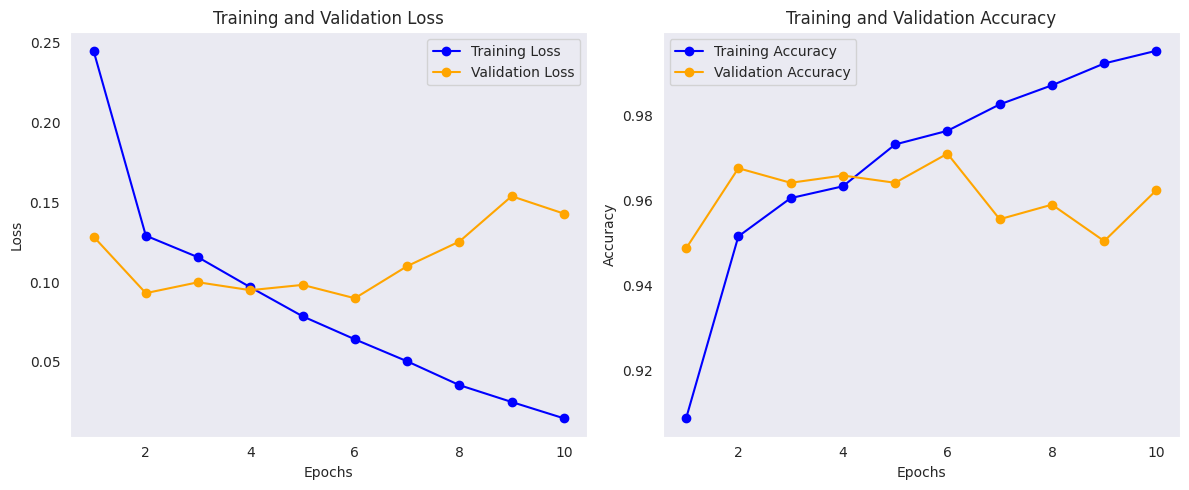

In [ ]:
# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

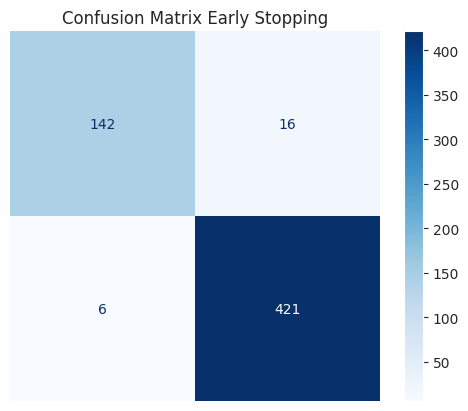

In [ ]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Early Stopping')
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
accuracy, precision, sensitivity, specificity, f1_score = calculate_metrics(conf_matrix)

# Print metrics
print(f'EARLY STOPPING MODEL')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score: {f1_score:.4f}')

EARLY STOPPING MODEL
Accuracy: 0.9624
Precision: 0.9634
Sensitivity (Recall): 0.9859
Specificity: 0.8987
F1 Score: 0.9745


###**Discussion of Results**

In this case, training stopped after 10 epochs, as validation loss failed to improve for 4 consecutive epochs, indicating a plateau in validation performance. The early stopping implementation successfully prevented overfitting, as the model ceased training when it had reached optimal performance on the validation set, rather than memorizing the training data. This not only resulted in a model with better generalization to new data but also saved training time, yielding a more efficient and effective model overall.

# Final Evaluation

Final evaluation of the performance of the model.

The results indicate that a relatively shallow CNN model can effectively classify pneumonia, achieving high accuracy and robust performance metrics across multiple evaluation criteria. The optimized model results presented suggest that the model is highly effective in identifying cases of pneumonia with minimal false negatives. Additionally, the specificity indicates good discrimination of non-pneumonia cases, though there is some room for improvement in reducing false positives.

These results highlight that very deep CNN architectures, with hundreds of layers, are not strictly necessary to achieve strong performance in pneumonia classification. This finding has practical implications: a lighter model requires less computational power and memory, making it feasible to deploy in clinical settings with limited hardware.


In [ ]:
# Implement evaluation here

def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Set model to evaluation mode
    test_loss, correct = 0, 0

    # Lists to store all true and predicted labels
    y_true = []
    y_pred = []

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for X, y in dataloader:
            # Move data to the appropriate device (CPU or GPU)
            X, y = X.to(device), y.to(device)
            y = y.float()

            # Get model predictions
            pred = model(X)

            # Calculate loss and update test_loss
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()

            # Update the number of correct predictions for binary classification
            predicted_labels = (pred >= 0.5).float()
            correct += (predicted_labels == y.unsqueeze(1)).type(torch.float).sum().item()

            # Store true and predicted values for confusion matrix
            y_true.extend(y.cpu().numpy())  # true labels
            y_pred.extend(predicted_labels.squeeze().cpu().numpy())  # predicted labels

    # Compute average loss and accuracy
    test_loss /= num_batches
    accuracy = correct / size

    # Print the test performance
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    return y_true, y_pred

In [ ]:
# Initialize the model architecture (use the same architecture as during training)
model = OptimizedModel()
model.load_state_dict(torch.load('chest_xray_optimized_model.pth', weights_only=True))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device to GPU if available, else CPU
model.to(device)

OptimizedModel(
  (layers): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=65536, out_features=1, bias=True)
)

###**Results Test Set Optimized Model**

Test Loss: 0.1621, Test Accuracy: 0.9353


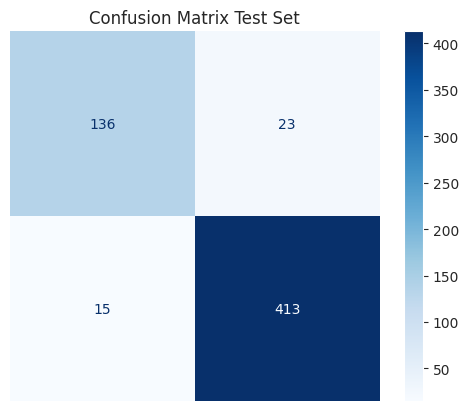

Test Metrics Optimized Model
Accuracy: 0.9353
Precision: 0.9472
Sensitivity (Recall): 0.9650
Specificity: 0.8553
F1 Score: 0.9560


In [ ]:
# Test the model on the test set
y_true, y_pred = test(test_dataloader, model, criterion, device)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Test Set')
plt.axis('off')  # Turn off axis
plt.show()

accuracy, precision, sensitivity, specificity, f1_score = calculate_metrics(conf_matrix)

# Print metrics
print(f'Test Metrics Optimized Model')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score: {f1_score:.4f}')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%shell
jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/COMP0188: Deep Representations and Learning/24222924–CW-pythonNB.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/COMP0188: Deep Representations and Learning/24222924–CW-pythonNB.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 19 image(s).
[NbConvertApp] Writing 3085986 bytes to /content/drive/MyDrive/Colab Notebooks/COMP0188: Deep Representations and Learning/24222924–CW-pythonNB.html
